## 最終課題_オリジナルAIの構築

ディープラーニングの手法（教師あり学習の二値分類モデル）およびTensorflow・Kerasを用いて、問題を解決するAIを構築する。

音声データファイルを読み込み学習して、「普通」「喜び」の2種類に分類するAIを構築した。<br>
(普通、喜びともにデータ数は300)

> データ元 : 日本声優統計学会 https://voice-statistics.github.io/

*事前チェック*

In [1]:
import os
import glob
import librosa
import numpy as np

# 現在の作業ディレクトリを確認
print(f"現在の作業ディレクトリ: {os.getcwd()}")

# フォルダとファイルの存在確認
print("\n=== フォルダ・ファイル確認 ===")
folders = ["./dataset_sample/train", "./dataset_sample/train/normal", "./dataset_sample/train/happy", "./dataset_sample/test", "./dataset_sample/test/normal", "./dataset_sample/test/happy"]

for folder in folders:
    if os.path.exists(folder):
        files = os.listdir(folder)
        wav_files = [f for f in files if f.endswith('.wav')]
        print(f"✅ {folder}: {len(wav_files)} .wavファイル")
        if wav_files:
            print(f"   例: {wav_files[0]}")
    else:
        print(f"❌ {folder}: フォルダが存在しません")

# globでの検索結果
print("\n=== glob検索結果 ===")
patterns = ["./dataset_sample/train/normal/*.wav", "./dataset_sample/train/happy/*.wav", "./dataset_sample/test/normal/*.wav", "./dataset_sample/test/happy/*.wav"]

all_files = []
for pattern in patterns:
    files = glob.glob(pattern)
    print(f"{pattern}: {len(files)} ファイル")
    if files:
        print(f"   最初のファイル: {files[0]}")
        all_files.extend(files)

if not all_files:
    print("\n❌ 音声ファイルが1つも見つかりません")
    print("以下を確認してください:")
    print("1. フォルダ構造が正しいか")
    print("2. .wavファイルが存在するか")
    print("3. ファイルパスが正しいか")
else:
    print(f"\n✅ 合計 {len(all_files)} ファイルが見つかりました")
    
    # 最初のファイルで読み込みテスト
    test_file = all_files[0]
    print(f"\n=== 読み込みテスト: {test_file} ===")
    
    try:
        # ファイルサイズ確認
        size = os.path.getsize(test_file)
        print(f"ファイルサイズ: {size} bytes")
        
        # librosaで読み込み
        audio, sr = librosa.load(test_file, sr=None)
        print(f"✅ 読み込み成功")
        print(f"   サンプリングレート: {sr} Hz")
        print(f"   音声長: {len(audio)} サンプル ({len(audio)/sr:.2f} 秒)")
        
        # MFCC抽出テスト
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        print(f"✅ MFCC抽出成功: {mfccs.shape}")
        
    except Exception as e:
        print(f"❌ 読み込みエラー: {e}")
        print(f"エラータイプ: {type(e).__name__}")


現在の作業ディレクトリ: c:\dev\aidev\Lesson13

=== フォルダ・ファイル確認 ===
✅ ./dataset_sample/train: 0 .wavファイル
✅ ./dataset_sample/train/normal: 210 .wavファイル
   例: fujitou_normal_001.wav
✅ ./dataset_sample/train/happy: 210 .wavファイル
   例: fujitou_happy_031.wav
✅ ./dataset_sample/test: 0 .wavファイル
✅ ./dataset_sample/test/normal: 90 .wavファイル
   例: fujitou_normal_071.wav
✅ ./dataset_sample/test/happy: 90 .wavファイル
   例: fujitou_happy_001.wav

=== glob検索結果 ===
./dataset_sample/train/normal/*.wav: 210 ファイル
   最初のファイル: ./dataset_sample/train/normal\fujitou_normal_001.wav
./dataset_sample/train/happy/*.wav: 210 ファイル
   最初のファイル: ./dataset_sample/train/happy\fujitou_happy_031.wav
./dataset_sample/test/normal/*.wav: 90 ファイル
   最初のファイル: ./dataset_sample/test/normal\fujitou_normal_071.wav
./dataset_sample/test/happy/*.wav: 90 ファイル
   最初のファイル: ./dataset_sample/test/happy\fujitou_happy_001.wav

✅ 合計 600 ファイルが見つかりました

=== 読み込みテスト: ./dataset_sample/train/normal\fujitou_normal_001.wav ===
ファイルサイズ: 1006198 bytes
✅ 読み込み成功
   

*ライブラリのインポート*

In [2]:
# 必要なライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import librosa

# TensorFlow
import tensorflow as tf

# データの分割
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# DataFrameですべての列を表示する設定
pd.options.display.max_columns = None

*データの読み込み*

In [3]:
# 音声データの読み込み関数
def load_audio_data():
    """
    音声データを読み込んでMNIST形式に変換
    """
    # trainフォルダのファイル一覧を取得
    train_normal_files = glob.glob("./dataset_sample/train/normal/*.wav")
    train_happy_files = glob.glob("./dataset_sample/train/happy/*.wav")
    
    # testフォルダのファイル一覧を取得
    test_normal_files = glob.glob("./dataset_sample/test/normal/*.wav")
    test_happy_files = glob.glob("./dataset_sample/test/happy/*.wav")
    
    print(f'train_normal_files: {len(train_normal_files)}')
    print(f'train_happy_files: {len(train_happy_files)}')
    print(f'test_normal_files: {len(test_normal_files)}')
    print(f'test_happy_files: {len(test_happy_files)}')
    
    def extract_features(file_path, max_pad_len=174):
        try:
            # 音声読み込み
            audio, sample_rate = librosa.load(file_path, sr=22050)
            
            # 音声データの確認
            if len(audio) == 0 or len(audio) < 1024:
                return None
            
            # MFCC特徴量抽出
            mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
            
            # パディングまたはトリミング
            pad_width = max_pad_len - mfccs.shape[1]
            if pad_width > 0:
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfccs = mfccs[:, :max_pad_len]
            
            return mfccs
            
        except Exception as e:
            print(f"エラー in {os.path.basename(file_path)}: {e}")
            return None
    
    def load_files(normal_files, happy_files, data_type=""):
        features = []
        labels = []
        success_count = 0
        fail_count = 0
        
        print(f"\n{data_type} データ処理開始...")
        
        # normalファイル処理
        if normal_files:
            print(f"normal ファイル処理中... ({len(normal_files)} ファイル)")
            for i, file_path in enumerate(normal_files):
                feature = extract_features(file_path)
                if feature is not None:
                    features.append(feature)
                    labels.append(0)  # normal = 0
                    success_count += 1
                else:
                    fail_count += 1
                
                # 進捗表示
                if (i + 1) % 50 == 0 or (i + 1) == len(normal_files):
                    print(f"  normal処理済み: {i + 1}/{len(normal_files)}")
        
        # happyファイル処理
        if happy_files:
            print(f"happy ファイル処理中... ({len(happy_files)} ファイル)")
            for i, file_path in enumerate(happy_files):
                feature = extract_features(file_path)
                if feature is not None:
                    features.append(feature)
                    labels.append(1)  # happy = 1
                    success_count += 1
                else:
                    fail_count += 1
                
                # 進捗表示
                if (i + 1) % 50 == 0 or (i + 1) == len(happy_files):
                    print(f"  happy処理済み: {i + 1}/{len(happy_files)}")
        
        print(f"{data_type} 処理完了: 成功={success_count}, 失敗={fail_count}")
        
        if len(features) == 0:
            print(f"❌ {data_type} データが1つも読み込めませんでした")
            return np.array([]).reshape(0, 40, 174), np.array([])
        
        return np.array(features), np.array(labels)
    
    # データ読み込み実行
    X_train, Y_train = load_files(train_normal_files, train_happy_files, "Train")
    X_test, Y_test = load_files(test_normal_files, test_happy_files, "Test")
    
    return (X_train, Y_train), (X_test, Y_test)

*データの確認*

In [4]:
# 音声データセットを読み込む
print("音声データ読み込み開始...")
(X_train, Y_train), (X_test, Y_test) = load_audio_data()

# データが正常に読み込まれたか確認
print(f"\n=== 読み込み結果確認 ===")
print(f"X_train.shape: {X_train.shape}")
print(f"Y_train.shape: {Y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"Y_test.shape: {Y_test.shape}")

# データが空でないことを確認
if len(X_train) == 0 or len(X_test) == 0:
    print("❌ データの読み込みに失敗しました")
    exit()

# X_trainの先頭1行を表示
print(f"\nX_train[0] shape: {X_train[0].shape}")
print(f"X_train[0] sample values:\n{X_train[0][:5, :5]}")  # 最初の5x5だけ表示

# Y_trainの先頭1行を表示
print(f"Y_train[0]: {Y_train[0]}")

音声データ読み込み開始...
train_normal_files: 210
train_happy_files: 210
test_normal_files: 90
test_happy_files: 90

Train データ処理開始...
normal ファイル処理中... (210 ファイル)
  normal処理済み: 50/210
  normal処理済み: 100/210
  normal処理済み: 150/210
  normal処理済み: 200/210
  normal処理済み: 210/210
happy ファイル処理中... (210 ファイル)
  happy処理済み: 50/210
  happy処理済み: 100/210
  happy処理済み: 150/210
  happy処理済み: 200/210
  happy処理済み: 210/210
Train 処理完了: 成功=420, 失敗=0

Test データ処理開始...
normal ファイル処理中... (90 ファイル)
  normal処理済み: 50/90
  normal処理済み: 90/90
happy ファイル処理中... (90 ファイル)
  happy処理済み: 50/90
  happy処理済み: 90/90
Test 処理完了: 成功=180, 失敗=0

=== 読み込み結果確認 ===
X_train.shape: (420, 40, 174)
Y_train.shape: (420,)
X_test.shape: (180, 40, 174)
Y_test.shape: (180,)

X_train[0] shape: (40, 174)
X_train[0] sample values:
[[-6.6133337e+02 -6.6109290e+02 -6.6072058e+02 -6.6133435e+02
  -6.6120496e+02]
 [ 2.6155657e-01  6.0141730e-01  1.1274053e+00  2.6010272e-01
   4.4310170e-01]
 [ 2.6128376e-01  6.0065204e-01  1.1250718e+00  2.6004395e-01
   4.428693

*データの前処理*

In [16]:
# len関数を使い、X_trainを(X_trainの長さ, 40, 174, 1)にreshapeしてX_train2に代入
X_train2 = X_train.reshape(len(X_train), 40, 174, 1)

# len関数を使い、X_testを(X_testの長さ, 40, 174, 1)にreshapeしてX_test2に代入
X_test2 = X_test.reshape(len(X_test), 40, 174, 1)

# データの正規化
print("\nデータ正規化中...")
X_train2 = (X_train2 - X_train2.min()) / (X_train2.max() - X_train2.min() + 1e-8)
X_test2 = (X_test2 - X_test2.min()) / (X_test2.max() - X_test2.min() + 1e-8)

# to_categoricalを使い、Y_trainをカテゴリー変数に展開してY_train2に代入
Y_train2 = tf.keras.utils.to_categorical(Y_train, num_classes=2)

# to_categoricalを使い、Y_testをカテゴリー変数に展開してY_test2に代入
Y_test2 = tf.keras.utils.to_categorical(Y_test, num_classes=2)

# X_train2, Y_train2, X_test2, Y_test2の形状を確認
print(f"\n前処理後のデータ形状:")
print(f"X_train2.shape: {X_train2.shape}")
print(f"Y_train2.shape: {Y_train2.shape}")
print(f"X_test2.shape: {X_test2.shape}")
print(f"Y_test2.shape: {Y_test2.shape}")


データ正規化中...

前処理後のデータ形状:
X_train2.shape: (420, 40, 174, 1)
Y_train2.shape: (420, 2)
X_test2.shape: (180, 40, 174, 1)
Y_test2.shape: (180, 2)


In [ ]:
# 元のテストデータを保持
X_test_origin = X_test2.copy()
Y_test_origin = Y_test2.copy()

# train_test_splitを使い、学習データと検証データに7:3（検証データが3割）で分割する
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train2, Y_train2, test_size=0.3, random_state=0)
X_train2, X_valid2, Y_train2, Y_valid2 = train_test_split(X_train2, Y_train2, test_size=0.3, random_state=0)

# X_train2, Y_train2, X_valid2, Y_valid2, X_test2, Y_test2の形状を確認
print(f"\n分割後のデータ形状:")
print(f"X_train2.shape: {X_train2.shape}")
print(f"Y_train2.shape: {Y_train2.shape}")
print(f"X_valid2.shape: {X_valid2.shape}")
print(f"Y_valid2.shape: {Y_valid2.shape}")
print(f"X_test2.shape: {X_test2.shape}")
print(f"Y_test2.shape: {Y_test2.shape}")


分割後のデータ形状:
X_train2.shape: (205, 40, 174, 1)
Y_train2.shape: (205, 2)
X_valid2.shape: (89, 40, 174, 1)
Y_valid2.shape: (89, 2)
X_test2.shape: (126, 40, 174, 1)
Y_test2.shape: (126, 2)


*モデルの構築*

In [18]:
# モデル初期化～構築
model = tf.keras.Sequential([
    # 入力層
    tf.keras.Input(shape=(40, 174, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same", strides=1, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", strides=1, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    # 隠れ層
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    # 出力層（2クラス分類）
    tf.keras.layers.Dense(2, activation='softmax')
])

# モデルの構築
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

# モデルの構造を表示
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 40, 174, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 27520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,522,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,549,890 (13.54 MB)

 Trainable params: 3,549,890 (13.54 MB)

 Non-trainable params: 0 (0.00 B)

X_train2の形状: (205, 40, 174, 1)
X_train2のデータ型: float32
X_train2の値の範囲: 0.0 ~ 1.0
Y_train2の形状: (205, 2)
Y_train2のユニークな値: [0. 1.]

モデル学習開始...
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4488 - loss: 1.0497 - val_accuracy: 0.4831 - val_loss: 0.6985
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5463 - loss: 0.6923 - val_accuracy: 0.5169 - val_loss: 0.6912
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5122 - loss: 0.6961 - val_accuracy: 0.4831 - val_loss: 0.6916
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5463 - loss: 0.6932 - val_accuracy: 0.4831 - val_loss: 0.6910
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5659 - loss: 0.6897 - val_accuracy: 0.5169 - val_loss: 0.6861
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5317 - loss: 0.6928 - val_accuracy: 0.5169 - val_loss: 0.6864
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5805 - loss: 0.6877 - val_accuracy: 0.8090

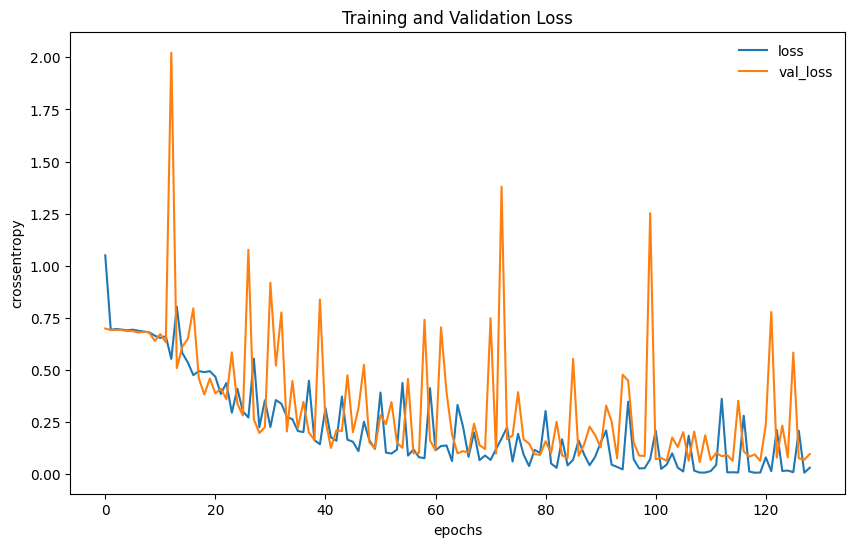

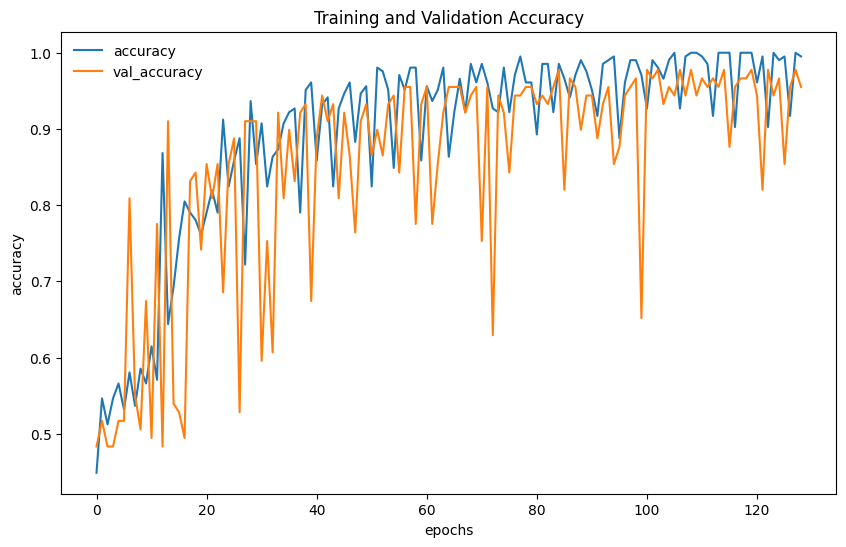

In [19]:
# データの形状と型を確認
print("X_train2の形状:", X_train2.shape)
print("X_train2のデータ型:", X_train2.dtype)
print("X_train2の値の範囲:", X_train2.min(), "~", X_train2.max())
print("Y_train2の形状:", Y_train2.shape)
print("Y_train2のユニークな値:", np.unique(Y_train2))

# 学習の実施
print("\nモデル学習開始...")
log = model.fit(X_train2, Y_train2, epochs=200, batch_size=32, verbose=True,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            min_delta=0, patience=20,
                                                            verbose=1)],
                validation_data=(X_valid2, Y_valid2))

# 学習過程をグラフ表示
plt.figure(figsize=(10, 6))
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.title("Training and Validation Loss")
plt.show()

# 精度もグラフ表示
plt.figure(figsize=(10, 6))
plt.plot(log.history['accuracy'], label='accuracy')
plt.plot(log.history['val_accuracy'], label='val_accuracy')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

In [20]:
# predictを使い、X_test2をもとに予測した結果を、
# カテゴリー変数へ復元してY_pred2に代入
Y_pred2 = np.argmax(model.predict(X_test2), axis=1)

# Y_test2もカテゴリー変数へ復元して、Y_test2_ に代入
Y_test2_ = np.argmax(Y_test2, axis=1)

# データ形状の確認
print(f"Y_test2_ shape: {Y_test2_.shape}")
print(f"Y_pred2 shape: {Y_pred2.shape}")
print(f"Y_test2_ type: {type(Y_test2_)}")
print(f"Y_pred2 type: {type(Y_pred2)}")

# classification_reportを使い、モデルの評価を実施
target_names = ['normal', 'happy']
print(f"\n")
print(classification_report(Y_test2_, Y_pred2, target_names=target_names))

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000021F1D901E40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Y_test2_ shape: (126,)
Y_pred2 shape: (126,)
Y_test2_ type: <class 'numpy.ndarray'>
Y_pred2 type: <class 'numpy.ndarray'>


              precision    recall  f1-score   support

      normal       

*追加：視覚的に見やすくする*

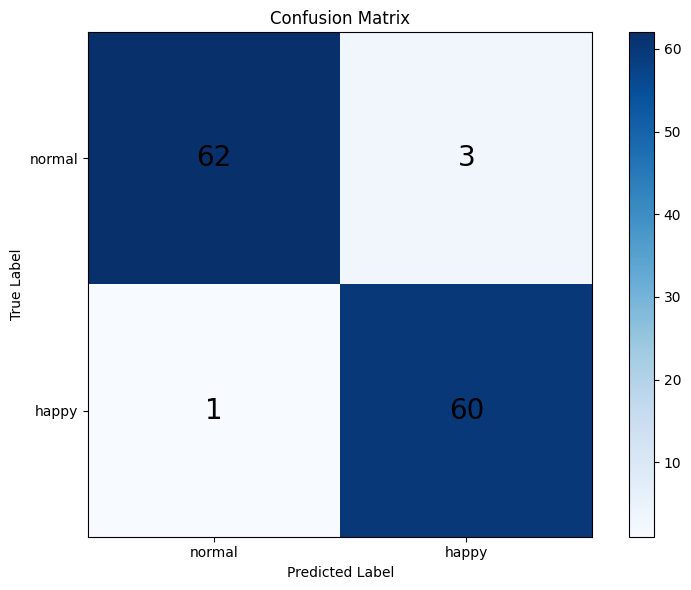


混同行列:
実際\予測  normal  happy
normal        62      3
happy          1     60

テスト精度: 0.9683


In [21]:
# 混同行列の表示
cm = confusion_matrix(Y_test2_, Y_pred2)

# matplotlibで混同行列を表示
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# ラベルを追加
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names)
plt.yticks(tick_marks, target_names)

# 数値を表示
for i in range(len(target_names)):
    for j in range(len(target_names)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=20)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(f"\n混同行列:")
print(f"実際\\予測  normal  happy")
print(f"normal     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"happy      {cm[1,0]:5d}  {cm[1,1]:5d}")

# テスト精度の表示
test_accuracy = np.mean(Y_test2_ == Y_pred2)
print(f"\nテスト精度: {test_accuracy:.4f}")
